# Exploratory Data Analysis
The objective of this notebook is to compute some statistics and visualizations to understand the data better once the corpus is created.

In [1]:
import pandas as pd
import numpy as np
import requests
from dotenv import load_dotenv
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidzhu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/davidzhu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidzhu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
DATA_PATH = os.path.join("..", 'data')
CORPUS_FILENAME = 'dataset-v1.pkl'

CORPUS_FILE = os.path.join(DATA_PATH, CORPUS_FILENAME)

## Import Corpus

In [3]:
input_df = pd.read_pickle(CORPUS_FILE)

In [4]:
# convert every issue that is not "spam" to "not-spam"
df = pd.DataFrame(columns=['label', 'text'])
df['label'] = input_df['labels'].apply(lambda x: 'spam' if 'spam' in x else 'not-spam')
df['text'] = input_df['title'] + " " + input_df['body']

## Preprocess
Before analyzing the text data, it's best-practice to do pre-processing. For reference, read [this article](https://medium.com/@maleeshadesilva21/preprocessing-steps-for-natural-language-processing-nlp-a-beginners-guide-d6d9bf7689c9)
- Stem
- Lemmatize
- Lowercase
- etc

### Define regex that will be used to clean the text

In [5]:
code_block_pattern = r"```([\w\W]*?)```" # matches all code blocks enclosed in triple backticks ```
code_pattern = r"`([\w\W]*?)`" # matches all code blocks enclosed in single backticks `
url_pattern = r"http\S+" # matches all urls
new_line_pattern = r'[\r|\n]' # matches all new lines and carriage returns
non_word_pattern = r'[^\w\s]' # matches all non-word characters (only retains alphanumeric and underscores)
number_pattern = r'\S*\d+\S*' # matches all words that contain numbers

def clean(text):
    text = re.sub(code_block_pattern, ' ', text)
    text = re.sub(code_pattern, ' ', text)
    text = re.sub(url_pattern, ' ', text)
    text = re.sub(new_line_pattern, ' ', text)
    text = re.sub(non_word_pattern, '', text)
    text = re.sub(number_pattern, ' ', text)
    return text

### Applying lowercase for all characters and preprocessing the data
The data is cleaned using the regex defined above

In [6]:
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

df['text'] = df['text'].apply(clean)

### Tokenization

In [7]:
df['text'] = df['text'].apply(word_tokenize)

### Removing stop words

In [8]:
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stop_words])
df

,label,text
0,not-spam,"[missing, migrations, libavif, pinned, condafo..."
1,not-spam,"[ui, feedback, uag, search, button, need, clic..."
2,not-spam,"[issues, resolved, welcome, repository]"
3,not-spam,"[create, account, rules, broken, error, prompt]"
4,not-spam,"[nan, search, results, table, general, questio..."
...,...,...
1816,spam,"[want, explicit, sex, secs, ring, costs, gsex,..."
1817,spam,"[asked, chatlines, inclu, free, mins, india, c..."
1818,spam,"[contract, mobile, mnths, latest, motorola, no..."
1819,spam,"[reminder, get, pounds, free, call, credit, de..."


### Lemmatization

In [9]:
lemmatizer = WordNetLemmatizer()

# define function to lemmatize tokens
def lemmatize_tokens(tokens):
    # convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    # lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    # return lemmatized tokens as a list
    return lemmas
    

# apply lemmatization function to column of dataframe
df['lemmatized_text'] = df['text'].apply(lemmatize_tokens)

In [10]:
spam_df = df[df['label'] == 'spam']
non_spam_df = df[df['label'] == 'not-spam']

## Statistics
We can learn a lot about our text data through standard statistical metrics. For reference, read [this article](https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools). Compute each statistic individually for spam and not-spam issues

### Average token count

In [11]:
spam_average_token_count =  spam_df['lemmatized_text'].apply(lambda x: len(x)).mean()
non_spam_average_token_count = non_spam_df['lemmatized_text'].apply(lambda x: len(x)).mean()

print(f"Average token count for spam issues: {spam_average_token_count:.2f}")
print(f"Average token count for non-spam issues: {non_spam_average_token_count:.2f}")

Average token count for spam issues: 18.67
Average token count for non-spam issues: 53.76


### Type-Token ratio

In [12]:
total_spam_words = spam_df['lemmatized_text'].explode()
unique_spam_words = total_spam_words.unique()

total_non_spam_words = non_spam_df['lemmatized_text'].explode()
unique_non_spam_words = total_non_spam_words.unique()

In [13]:
print(f"Total spam words: {len(total_spam_words)}")
print(f"Unique spam words: {len(unique_spam_words)}")
print(f"Total non-spam words: {len(total_non_spam_words)}")
print(f"Unique non-spam words: {len(unique_non_spam_words)}")

print(f"Type token ratio for spam: {len(unique_spam_words) / len(total_spam_words):.3f}")
print(f"Type token ratio for non-spam: {len(unique_non_spam_words) / len(total_non_spam_words):.3f}")

Total spam words: 15327
Unique spam words: 2500
Total non-spam words: 53764
Unique non-spam words: 9120
Type token ratio for spam: 0.163
Type token ratio for non-spam: 0.170


## Visualizations
Visualize each of the following individually for spam and not-spam issues. [Reference](https://medium.com/@melody.zapotoczny/a-quick-easy-guide-to-text-analysis-seaborn-4c1a20addba3)
- Most frequent unigrams (words), bigrams(pairs of words), trigrams
- Average issue content (issue title + issue body) length
- Histogram of issue content length

In [14]:
common_spam_words = Counter(total_spam_words).most_common(10)
common_non_spam_words = Counter(total_non_spam_words).most_common(10)

spam_words, spam_count = zip(*common_spam_words)
non_spam_words, non_spam_count = zip(*common_non_spam_words)

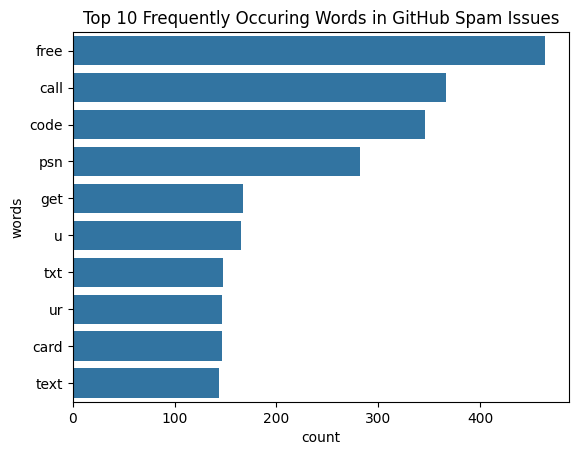

In [15]:
plot = sns.barplot(
    data={'words': spam_words, 'count': spam_count},
    x='count', 
    y='words').set_title('Top 10 Frequently Occuring Words in GitHub Spam Issues')


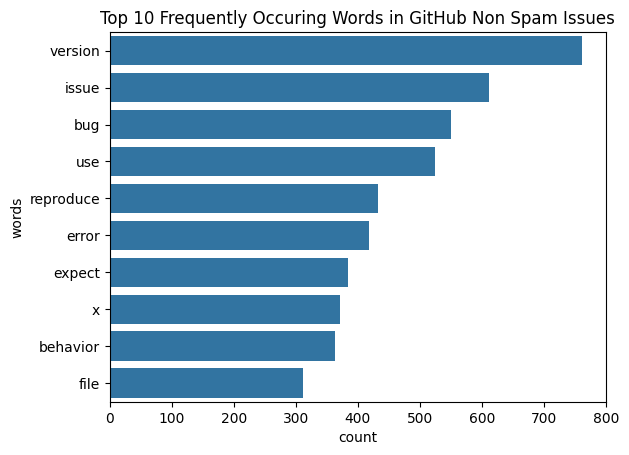

In [16]:
plot = sns.barplot(
    data={'words': non_spam_words, 'count': non_spam_count},
    x='count', 
    y='words').set_title('Top 10 Frequently Occuring Words in GitHub Non Spam Issues')


In [17]:
def get_top_ngram(corpus: pd.DataFrame, n: int):
    cv = CountVectorizer(ngram_range=(n,n))
    ngrams = cv.fit_transform(corpus)

    vocab = cv.vocabulary_

    count_values = ngrams.toarray().sum(axis=0)

    return pd.DataFrame(sorted([(count_values[i], k) for k, i in vocab.items()], reverse = True))

Text(0.5, 1.0, 'Top 10 Most Frequently Occuring Bigrams in GitHub Spam Issues')

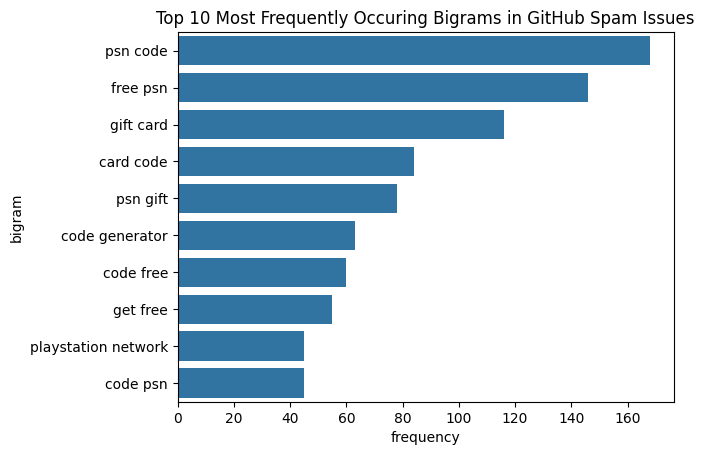

In [18]:
spam_bigrams = get_top_ngram(spam_df['lemmatized_text'].apply(lambda x: ' '.join(x)), 2)[:10]
sns.barplot(data={
    'frequency': spam_bigrams[0],
    'bigram': spam_bigrams[1]
},
x='frequency',
y='bigram').set_title('Top 10 Most Frequently Occuring Bigrams in GitHub Spam Issues')

Text(0.5, 1.0, 'Top 10 Most Frequently Occuring Bigrams in GitHub Non Spam Issues')

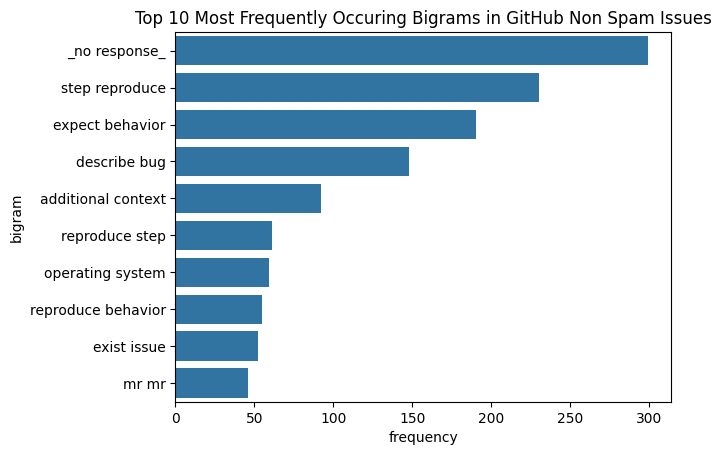

In [19]:
non_spam_bigram = get_top_ngram(non_spam_df['lemmatized_text'].apply(lambda x: ' '.join(x)), 2)[:10]
sns.barplot(data={
    'frequency': non_spam_bigram[0],
    'bigram': non_spam_bigram[1]
},
x='frequency',
y='bigram').set_title('Top 10 Most Frequently Occuring Bigrams in GitHub Non Spam Issues')

Text(0.5, 1.0, 'Top 10 Most Frequently Occuring Trigrams in GitHub Spam Issues')

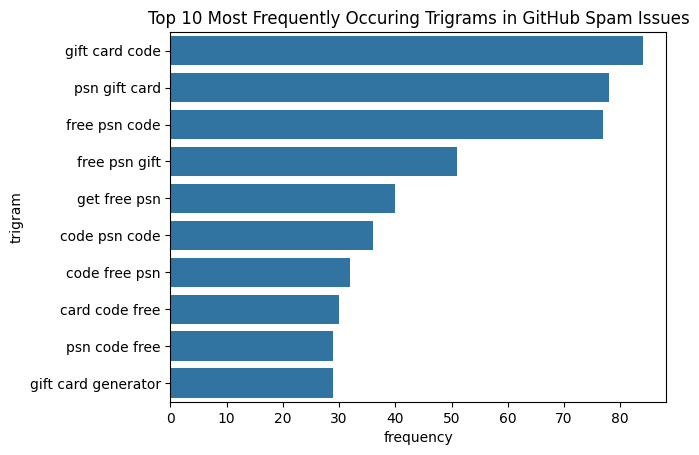

In [20]:
spam_trigrams = get_top_ngram(spam_df['lemmatized_text'].apply(lambda x: ' '.join(x)), 3)[:10]
sns.barplot(data={
    'frequency': spam_trigrams[0],
    'trigram': spam_trigrams[1]
},
x='frequency',
y='trigram').set_title('Top 10 Most Frequently Occuring Trigrams in GitHub Spam Issues')

Text(0.5, 1.0, 'Top 10 Most Frequently Occuring Trigram in GitHub Non Spam Issues')

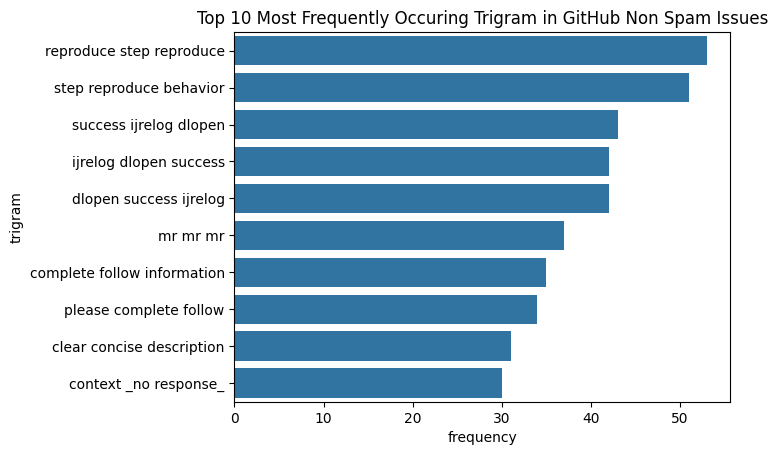

In [21]:
non_spam_trigram = get_top_ngram(non_spam_df['lemmatized_text'].apply(lambda x: ' '.join(x)), 3)[:10]
sns.barplot(data={
    'frequency': non_spam_trigram[0],
    'trigram': non_spam_trigram[1]
},
x='frequency',
y='trigram').set_title('Top 10 Most Frequently Occuring Trigram in GitHub Non Spam Issues')